In [17]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from calendar import month_abbr
import all_my_code as amc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

## Functions 

In [2]:
def read_contrib_data(fname):
    regions = ['STSS', 'SPSS', 'ICE']
    dataarrays = []
    for region in regions:
        da = xr.open_dataarray(fname.format(region=region)).rename(region)
        da = da.assign_coords(time=['DJF', 'MAM', 'JJA', 'SON', 'Annual'])
        dataarrays.append(da)

    da_merged = xr.merge(dataarrays).to_array(dim='region', name='contrib')
    return da_merged

def read_seas_cycle_driver(fname):
    regions = ['STSS', 'SPSS', 'ICE']
    seas_cycle = []
    for therm in ['thermal', 'nonthermal']:
        dataarray = []
        for region in regions:
            ds = xr.open_mfdataset(fname.format(region=region, therm=therm))
            key = list(ds.data_vars)[0]
            dataarray.append(
                ds[key]
                .rename(region)
                .isel(time=slice(0, 12))
                .assign_coords(
                    time=month_abbr[1:13],
                    driver=therm))
        seas_cycle += xr.merge(dataarray),
    seas_cycle = xr.concat(seas_cycle, dim='driver').to_array(dim='region', name='driver')
    return seas_cycle

## Read in data

In [3]:
# read in pCO2

In [4]:
contrib = xr.concat([
        read_contrib_data("./data/models_obs_M_temp_dic_{region}_v3.nc"),
        read_contrib_data("./data/dataproducts_D_temp_dic_SC_{region}_v1.nc").rename(product='model')],
    dim='model').assign_coords(model=[
    'CCSM WHOI',
    'CESM ETHZ',
    'CNRM ESM2',
    'EC Earth3',
    'FESOM REcoM HR',
    'FESOM REcoM LR',
    'MOM6 Princeton',
    'MPIOM HAMOCC',
    'MRI ESM2',
    'NorESM OC1',
    'ORCA025 GEOMAR',
    'ORCA1 LIM3 PISCES',
    'ROMS SouthernOcean ETHZ',
    'PlankTOM12',
    'BSOSE',
    'ECCO-Darwin',
    'Watson',
    'Data Products',
    'CMEMS-LSCE-FFNN',
    'CSIR-ML6',
    'JMA-MLR',
    'OceanSODA-ETHZ',
    'MPI-SOMFFN'
])

seas_cycle = xr.concat([
        read_seas_cycle_driver("./data/models_obs_{therm}_dpCO2*_dt_SC_{region}_v2.nc"),
        read_seas_cycle_driver("./data/dataproducts_{therm}_dpCO2sst_dt_SC_{region}_v1.nc").rename(product='model')],
    dim='model'
).assign_coords(model=[
    'CCSM WHOI',
    'CESM ETHZ',
    'CNRM ESM2',
    'EC Earth3',
    'FESOM REcoM HR',
    'FESOM REcoM LR',
    'MOM6 Princeton',
    'MPIOM HAMOCC',
    'MRI ESM2',
    'NorESM OC1',
    'ORCA025 GEOMAR',
    'ORCA1 LIM3 PISCES',
    'ROMS SouthernOcean ETHZ',
    'PlankTOM12',
    'BSOSE',
    'ECCO-Darwin',
    'Watson2020',
    'Data Products',
    'CMEMS-LSCE-FFNN',
    'CSIR-ML6',
    'JMA-MLR',
    'OceanSODA-ETHZ',
    'MPI-SOMFFN',
])

## Assign data type

In [5]:
types = [
    'model',        # CCSM WHOI
    'model',        # CESM ETHZ
    'model',        # CNRM ESM2
    'model',        # EC Earth3
    'model',        # FESOM REcoM HR
    'model',        # FESOM REcoM LR
    'model',        # MOM6 Princeton
    'model-bad',    # MPIOM HAMOCC
    'model',        # MRI ESM2
    'model',        # NorESM OC1
    'model',        # ORCA025 GEOMAR
    'model',        # ORCA1 LIM3 PISCES
    'model',        # ROMS SouthernOcean ETHZ
    'model',        # PlankTOM12
    'assim',        # BSOSE
    'assim',        # ECCO-Darwin
    'product',      # Watson2020
    'product_avg',  # Data Products
    'product',      # CMEMS-LSCE-FFNN
    'product',      # CSIR-ML6
    'product',      # JMA-MLR
    'product',      # OceanSODA-ETHZ
    'product',      # MPI-SOMFFN
]
contrib = contrib.assign_coords(type=xr.DataArray(types, dims='model'))
seas_cycle = seas_cycle.assign_coords(type=xr.DataArray(types, dims='model'))

sum_of_contrib = contrib.sel(region=['STSS', 'SPSS'], time='Annual').sum('region')
contrib = contrib.assign_coords(dic_strong=xr.DataArray(sum_of_contrib.values < 0, dims='model'))
seas_cycle = seas_cycle.assign_coords(dic_strong=xr.DataArray(sum_of_contrib.values < 0, dims='model'))

In [21]:
seasons = ['DJF', 'MAM', 'JJA', 'SON', 'Annual']

seas_contrib = xr.concat([
    contrib.where(lambda x: (x.type == 'product'), drop=True).mean('model').assign_coords(label='$p$CO$_2$-products'),
    contrib.where(lambda x: (x.type == 'model'), drop=True).mean('model').assign_coords(label='GOBMs'),
    contrib.where(lambda x: (x.type == 'model') & ( x.dic_strong.values), drop=True).mean('model').assign_coords(label='GOBMs\n(DIC dominant)'),
    contrib.where(lambda x: (x.type == 'model') & (~x.dic_strong.values), drop=True).mean('model').assign_coords(label='GOBMs\n(DIC weak)'),
], dim='label')

In [22]:
seasons = ['DJF', 'MAM', 'JJA', 'SON', 'Annual']

seas_contrib_all = xr.concat([
    contrib.sel(time=seasons, model=(contrib.type=='model') | (contrib.type=='model-bad') | (contrib.type=='assim')).drop(['dic_strong', 'type']),
    contrib.where(lambda x: (x.type == 'product')).mean('model').assign_coords(model='$p$CO$_2$-products')
], 'model')

In [23]:
pco2 = xr.open_dataset('../fig09/fig09_data.nc').groupby('time.month').mean('time')
data_classes = {
    'CCSM_WHOI': 'model-strong',
    'CESM_ETHZ': 'model-strong',
    'CNRM_ESM2_1': 'model-weak',
    'EC_Earth3': 'model-weak',
    'FESOM_REcoM_HR': 'model-weak',
    'FESOM_REcoM_LR': 'model-weak',
    'MOM6_Princeton': 'model-weak',
    'MRI_ESM2_1': 'model-strong',
    'NorESM_OC1_2': 'model-strong',
    'ORCA025_GEOMAR': 'model-strong',
    'ORCA1_LIM3_PISCES': 'model-weak',
    'PlankTOM12': 'model-weak',
    'BSOSE': 'model-weak',
    'ECCO_Darwin': 'model-weak',
    'AOML': 'product',
    'CMEMS_LSCE_FFNN': 'product',
    'CSIRML6': 'product',
    'JMAMLR': 'product',
    'JenaMLS': 'product',
    'NIES_ML3': 'product',
    'OceanSODAETHZ': 'product',
    'MPI_SOMFFN': 'product',
    'UOEX_Wat20': 'product',
    'LDEO_HPD': 'product'}

pco2.data_class.values[:] = [data_classes.get(k, 'bad') for k in pco2.model.values]
pco2 = pco2.spco2.groupby(pco2.data_class).mean().drop_sel(data_class='bad').sel(data_class=['product', 'model-strong', 'model-weak'])

# Plotting

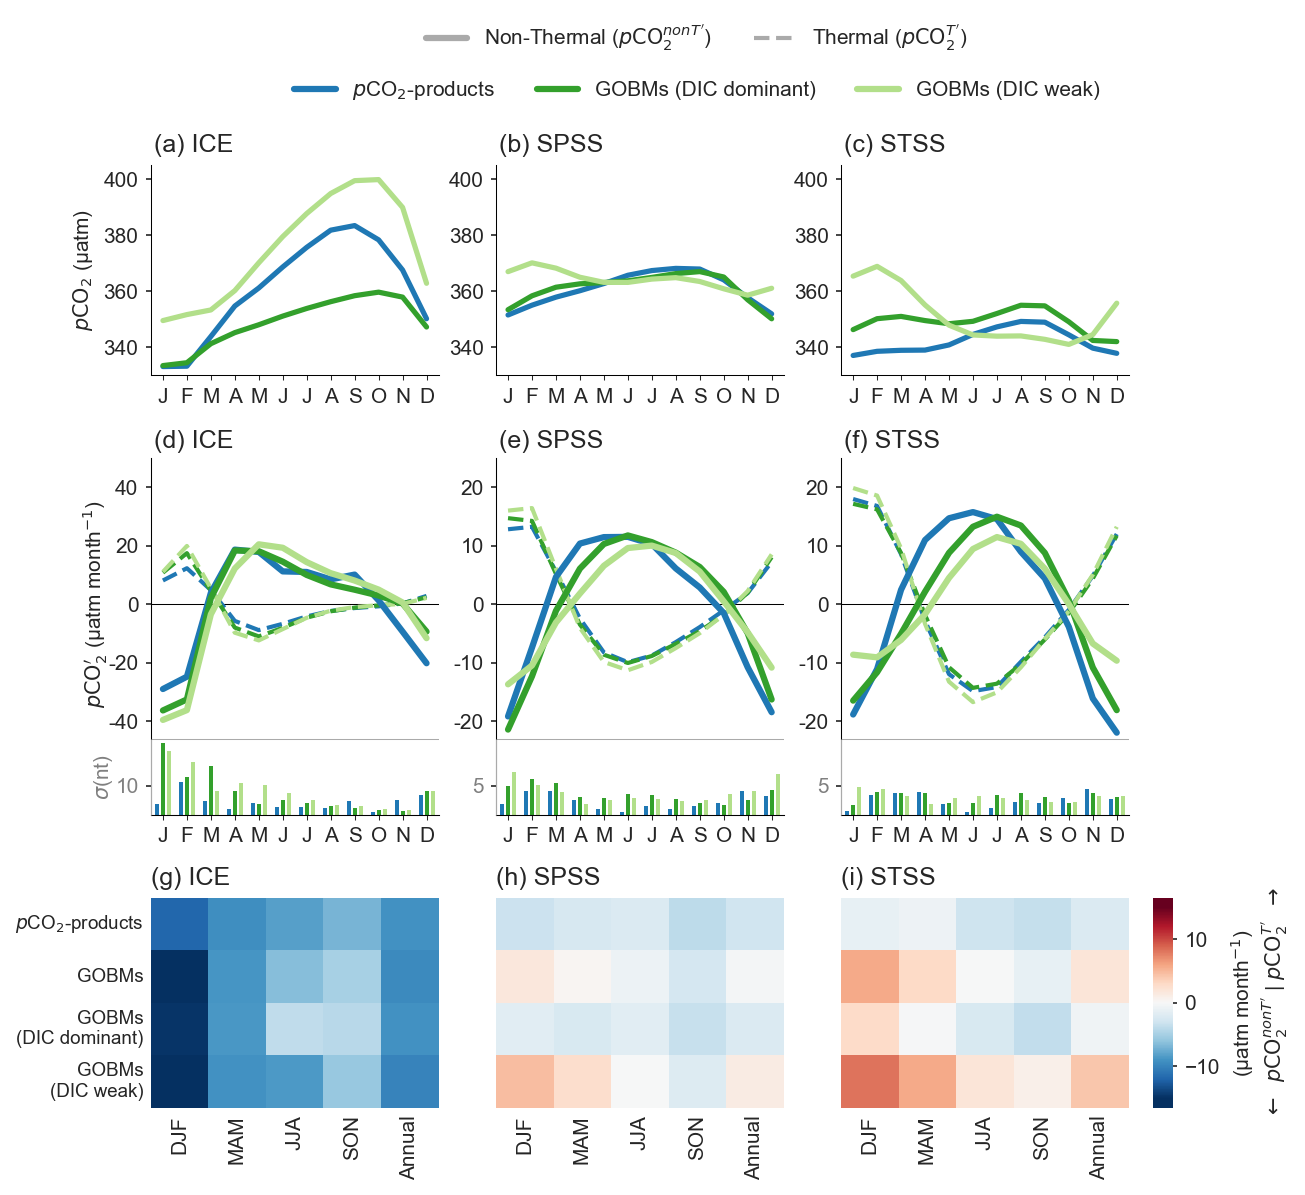

In [48]:
sns.set_palette('Paired')
fig = plt.figure(figsize=(8, 7), dpi=150)

shape = [7, 3]
ax0 = plt.subplot2grid(shape, [0, 0], rowspan=2, facecolor='none', fig=fig)
ax3 = plt.subplot2grid(shape, [2, 0], rowspan=3, facecolor='none', fig=fig)
ax6 = plt.subplot2grid(shape, [5, 0], rowspan=2, facecolor='none', fig=fig)
ax = np.array([
    ax0,
    plt.subplot2grid(shape, [0, 1], rowspan=2, facecolor='none', fig=fig, sharex=ax0),
    plt.subplot2grid(shape, [0, 2], rowspan=2, facecolor='none', fig=fig, sharex=ax0),
    ax3,
    plt.subplot2grid(shape, [2, 1], rowspan=3, facecolor='none', fig=fig, sharex=ax3),
    plt.subplot2grid(shape, [2, 2], rowspan=3, facecolor='none', fig=fig, sharex=ax3),
    ax6,
    plt.subplot2grid(shape, [5, 1], rowspan=2, facecolor='none', fig=fig, sharex=ax6),
    plt.subplot2grid(shape, [5, 2], rowspan=2, facecolor='none', fig=fig, sharex=ax6),
])
tax = [a.twinx() for a in ax[3:6]]

y0, y1 = -36, 25
y02 = y0 * 2
ax[3].set_ylim(y02, y1*2)
ax[4].set_ylim(y0, y1)
ax[5].set_ylim(y0, y1)
[t.set_ylim(0, np.abs(a.get_ylim()).sum()) for a, t in zip(ax[3:6], tax)]

[a.set_zorder(1) for a in ax]
[a.set_zorder(0) for a in tax]


labels = [
    '$p$CO$_2$-products',
    'GOBMs (DIC dominant)',
    'GOBMs (DIC weak)']
colors = ['C1', 'C3', 'C2']
props_therm = dict(lw=2, ls='--', zorder=1)
props_nonth = dict(lw=3, ls='-', zorder=2)

da = seas_cycle#.roll(time=0, roll_coords=True)
for i, r in enumerate(['ICE', 'SPSS', 'STSS']):
    
    plt.sca(ax[i + 3])
    dasub = da.sel(region=r, drop=True) 
    masks = [
        (dasub.type == 'product'),
        dasub.dic_strong.values & ((dasub.type == 'model') | (dasub.type == 'assim')),
        ~dasub.dic_strong.values & ((dasub.type == 'model') | (dasub.type == 'assim'))]
    
    width = 0.25
    offset = -width
    k = 0
    for mask, lbl, c in zip(masks, labels, colors):
        therm = dasub.where(mask, drop=True).sel(driver='thermal')
        nontherm = dasub.where(mask, drop=True).sel(driver='nonthermal')
        
        ### PLOTS ###
        therm.mean('model').plot(c=c, **props_therm)
        nontherm.mean('model').plot(c=c, label=lbl, **props_nonth)
        
        std = nontherm.std('model')
        sy = std.values
        sx = np.arange(sy.size) + offset

        tax[i].bar(sx, sy, color=c, width=width/1.5, lw=0)
        offset += width
        
        pco2.isel(data_class=k).sel(region=r).plot(ax=ax[i], c=c, label=lbl)

        k += 1

    plt.gca().legend().set_visible(0)


ax[0].set_title('(a) ICE',  x=0.01, y=0.98, ha='left', va='bottom')
ax[1].set_title('(b) SPSS', x=0.01, y=0.98, ha='left', va='bottom')
ax[2].set_title('(c) STSS', x=0.01, y=0.98, ha='left', va='bottom')

[a.set_xlabel('') for a in ax[:3]]
[a.set_ylabel('') for a in ax[1:3]]
[a.set_xticks(range(1, 13, 1)) for a in ax[:3]]
[a.set_xticklabels([m for m in 'JFMAMJJASOND']) for a in ax[:3]]
[a.set_xlim(0.5, 12.5) for a in ax[:3]]
ax[0].set_ylabel(r'$p\rm{CO}_2$ (µatm)')
ax[0].set_ylim([330, 405])
ax[1].set_ylim([330, 405])
ax[2].set_ylim([330, 405])

#################################
# xticks = [''] * 11
# xticks[1::3] = da.time.values[1::3]
# ax[0].set_xticks(range(1, 12, 1), xticks)
ax[3].set_xticks(range(0, 12, 1))
ax[3].set_xticklabels([m for m in 'JFMAMJJASOND'])

yticks_a = [y0+5, -20, -10, 0, 10, 20]
yticklabels_a = [5, -20, -10, 0, 10, 20]

yticks_b = [a*2 for a in yticks_a]
yticklabels_b = [a*2 for a in yticklabels_a]

ax[3].set_yticks(yticks_b)
ax[4].set_yticks(yticks_a)
ax[5].set_yticks(yticks_a)

ax[3].set_yticklabels(yticklabels_b)
ax[4].set_yticklabels(yticklabels_a)
ax[5].set_yticklabels(yticklabels_a)
[[[t.set_c('grey') for t in a.get_yticklabels()[:1]]] for a in ax[3:6]]

ax[3].axhline(-46, color='#aaaaaa', lw=0.5)
ax[4].axhline(-23, color='#aaaaaa', lw=0.5)
ax[5].axhline(-23, color='#aaaaaa', lw=0.5)

ax[3].set_clip_on(False)
[a.vlines(-0.5, y0*2, -46, colors=['#aaaaaa'], lw=0.5, clip_on=False, zorder=30) for a in ax[3:4]]
[a.vlines(-0.5, y0, -23, colors=['#aaaaaa'], lw=0.5, clip_on=False, zorder=30) for a in ax[4:6]]
ax[3].set_xlim(-0.5, 11.5)

[a.set_yticks([]) for a in tax]
[a.set_xlabel('') for a in ax[3:6]]
[a.set_ylabel('') for a in ax[3:6]]
[a.axhline(0, color='k', lw=0.5, zorder=0) for a in ax[3:6]]

ax[3].set_title('(d) ICE',  x=0.01, y=0.98, ha='left', va='bottom')
ax[4].set_title('(e) SPSS', x=0.01, y=0.98, ha='left', va='bottom')
ax[5].set_title('(f) STSS', x=0.01, y=0.98, ha='left', va='bottom')

ax[3].text(-2.2, 0, r"$p\rm{CO}_2'$ (µatm month$^{{-}1}$)", rotation=90, ha='right', va='center')
ax[3].text(-2., y02 + (-46 - y02) / 2, "$\sigma$(nt)", rotation=90, ha='right', va='center', color='grey')

lines_a = [l for l in ax[3].get_lines() if not l.get_label().startswith('_')]
lines_b = []
props_nonth.update(color='#aaaaaa')
props_therm.update(color='#aaaaaa')
lines_b += ax[3].plot(0, 0, **props_nonth, label="Non-Thermal ($p\mathrm{CO}_2^{nonT'}$)")
lines_b += ax[3].plot(0, 0, **props_therm, label="Thermal ($p\mathrm{CO}_2^{T'}$)")

labels_a = [l.get_label() for l in lines_a]
labels_b = [l.get_label() for l in lines_b]

fig.tight_layout()

fig.legend(lines_a, labels_a, ncol=3, loc='center', bbox_to_anchor=[0.54, 1.02])
fig.legend(lines_b, labels_b, ncol=2, loc='center', bbox_to_anchor=[0.54, 1.07])


####################################################################################
da = seas_contrib

props = dict(cmap='RdBu_r', vmin=-15, vmax=15, cbar=False)

sns.heatmap(da.sel(region='ICE').to_series().unstack(),  ax=ax[6], **props)
sns.heatmap(da.sel(region='SPSS').to_series().unstack(), ax=ax[7], **props)
sns.heatmap(da.sel(region='STSS').to_series().unstack(), ax=ax[8], **props)

[a.set_xlabel('') for a in ax[6:]]
[a.set_ylabel('') for a in ax[6:]]
[a.set_yticklabels([]) for a in ax[7:]]

[a.tick_params('y', length=0, labelsize=9) for a in ax[6:]]
[a.tick_params('x', length=0, rotation=90) for a in ax[6:]]

ax[6].set_title('(g) ICE', x=0.0, ha='left')
ax[7].set_title('(h) SPSS', x=0.0, ha='left')
ax[8].set_title('(i) STSS', x=0.0, ha='left')

fig.subplots_adjust(right=0.9, hspace=1.3, wspace=0.2)

p5 = ax[8].get_position()
cax = fig.add_axes([p5.x1 + 0.02, p5.y0, 0.017, p5.height])
cb = plt.colorbar(ax[8].get_children()[0], cax=cax, extend='both', extendfrac=0.05, extendrect=True)
cb.outline.set_lw(0)
cb.ax.tick_params(length=2)

cb.set_label("(µatm month$^{-1}$)\n$\leftarrow$  $p\mathrm{CO}_2^{nonT'}$ | $p\mathrm{CO}_2^{T'}$  $\\rightarrow$")#\n|$d$pCO$_2^{temp}$/$d$t| - |$d$pCO$_2^{DIC}$/$d$t| (µatm)')

fig.savefig('./fig07_driver_seas_cycle_decomp.pdf', bbox_inches='tight')
# fig.savefig('../figures/reccap2_driver_seas_cycle_decomp_update.png', dpi=300, bbox_inches='tight')

# Supplementary

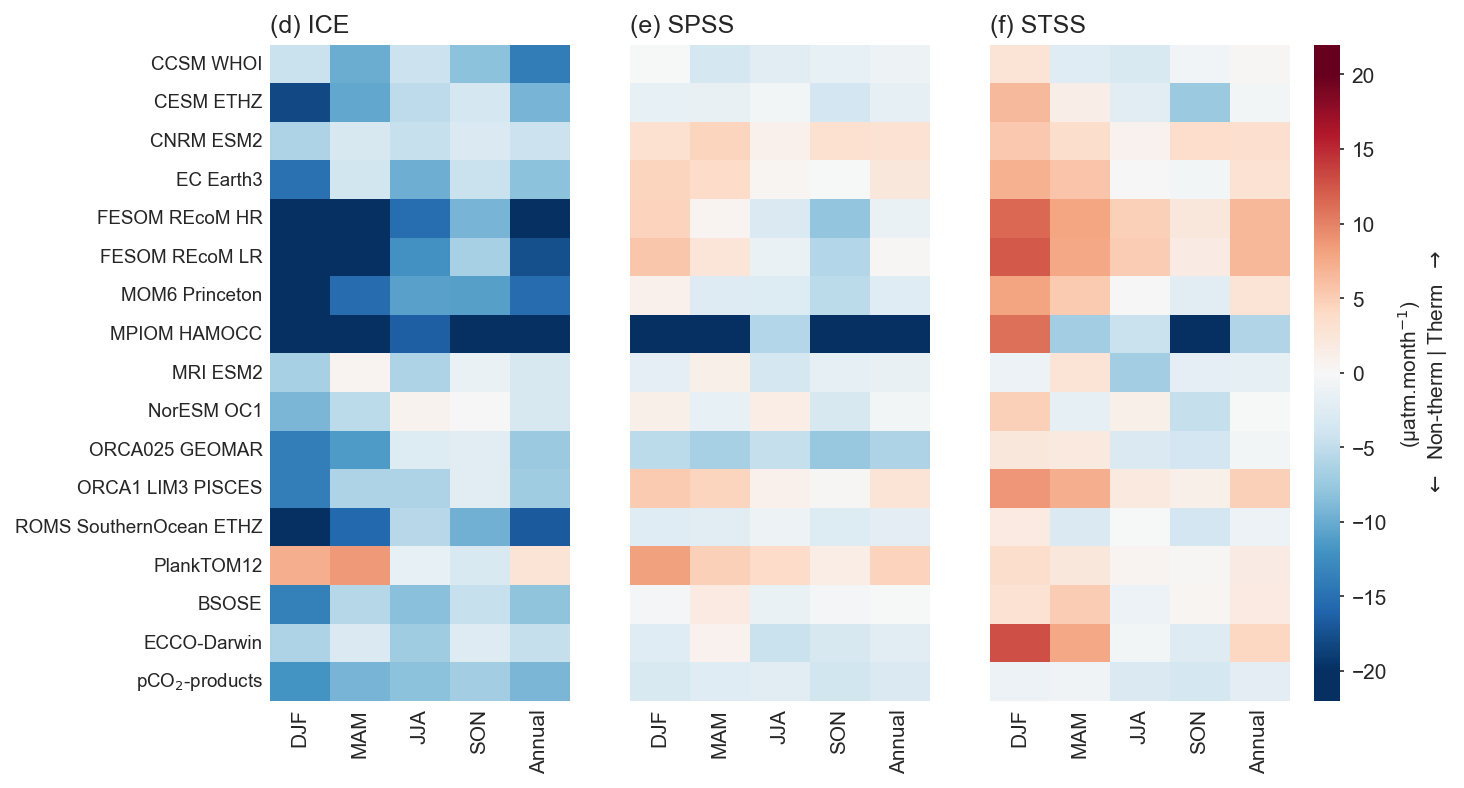

In [10]:
sns.set_palette('Paired')
fig, ax = plt.subplots(1, 3, figsize=(8, 5), dpi=150)
ax = np.array(ax)

da = seas_contrib_all

props = dict(cmap='RdBu_r', vmin=-20, vmax=20, cbar=False)

sns.heatmap(da.sel(region='ICE').to_series().unstack(), ax=ax[0], **props)
sns.heatmap(da.sel(region='SPSS').to_series().unstack(), ax=ax[1], **props)
sns.heatmap(da.sel(region='STSS').to_series().unstack(), ax=ax[2], **props)

[a.set_xlabel('') for a in ax]
[a.set_ylabel('') for a in ax]
[a.set_yticklabels([]) for a in ax[1:]]

[a.tick_params('y', length=0, labelsize=9) for a in ax]
[a.tick_params('x', length=0, rotation=90) for a in ax]

ax[0].set_title('(d) ICE', x=0.0, ha='left')
ax[1].set_title('(e) SPSS', x=0.0, ha='left')
ax[2].set_title('(f) STSS', x=0.0, ha='left')

fig.subplots_adjust(right=0.9, hspace=1.3, wspace=0.2)

p5 = ax[2].get_position()
cax = fig.add_axes([p5.x1 + 0.02, p5.y0, 0.022, p5.height])
cb = plt.colorbar(ax[0].get_children()[0], cax=cax, extend='both', extendfrac=0.05, extendrect=True)
cb.outline.set_lw(0)
cb.ax.tick_params(length=2)
cb.set_label('(µatm.month$^{-1}$)\n$\leftarrow$  Non-therm | Therm  $\\rightarrow$')#\n|$d$pCO$_2^{temp}$/$d$t| - |$d$pCO$_2^{DIC}$/$d$t| (µatm)')

fig.savefig('../figures/figureS11_seas_cycle_decomp.png', dpi=300, bbox_inches='tight')
fig.savefig('../figures/figureS11_seas_cycle_decomp.pdf', dpi=300, bbox_inches='tight')